In [1]:
import cupy
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [28]:
def interactions(a, np=numpy):
    return np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)

def half_iteration(a, mask, J = 1, beta = 1, np=numpy):
    deltaE = 2 * J * a * interactions(a, np=np)
    boltzmann = np.exp(-beta * deltaE) * mask
    flip_these = np.random.random(a.shape) < boltzmann
    a[flip_these] *= -1


def full_iteration(a, mask, J = 1, beta = 1, np=numpy):
    # this now becomes a VERY thin wrapper!
    half_iteration(a, mask, J, beta, np=np)
    half_iteration(a, 1-mask, J, beta, np=np)

def magnetization(a, np = numpy):
    mean_value = float(a.mean())
    std = float(a.std())
    return mean_value, std

def internal_energy(a, J = 1, np=numpy):
    current_energy = -J * a * interactions(a, np=np)
    mean_value = float(current_energy.mean())
    std = float(current_energy.std())
    return mean_value, std

Onsager_critical_temperature = 2 / np.log(1 + 2**0.5)

def cv(dE, T, k_B = 1):
    return dE**2 / k_B / T

def plots(T_range, E, dE, M, dM):
    plt.plot(T_range, E)
    plt.xlabel(r"Temperature [in units where $k_B = 1$]")
    plt.ylabel("Average energy per spin")
    plt.xlim(T_range.min(), T_range.max());
    plt.vlines(Onsager_critical_temperature, E.min(), E.max())

    plt.figure()

    plt.plot(T_range, M)
    plt.xlabel(r"Temperature [in units where $k_B = 1$]")
    plt.ylabel("Average magnetization")
    plt.xlim(T_range.min(), T_range.max());
    plt.axvline(Onsager_critical_temperature)


    plt.figure()
    plt.plot(T_range, Cv, "o-")
    plt.xlabel(r"Temperature [in units where $k_B = 1$]")
    plt.ylabel("Heat capacity per spin")
    plt.xlim(T_range.min(), T_range.max());
    plt.axvline(Onsager_critical_temperature)

T_range = np.linspace(1.5, 3.5, 300)
k_b = 1 # TODO RENAME TO k_B

def get_mask(size, np=numpy):
    a_mask = np.ones(size)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    return a_mask

def func(iterations, size, T, a_mask = None, k_b = k_b, np = numpy):
    if a_mask is None:
        a_mask = get_mask(size, np = np)
    beta = 1 / (k_b * T)
    a = np.ones(size)
    E_mean = 0.0
    E_std = 0.0
    M_mean = 0.0
    M_std = 0.0
    for i in range(iterations):
        energy = internal_energy(a, np=np)
        E_mean += energy[0]
        E_std += energy[1]
        magnet = magnetization(a, np=np)
        M_mean += magnet[0]
        M_std += magnet[1]
        full_iteration(a, a_mask, beta=beta, np=np)
    return a, E_mean / iterations, M_mean / iterations, E_std / iterations, M_std / iterations

def simulation(iterations, size, T_range=T_range, k_b=k_b, plotting=True, np=numpy):
    energies = []
    energies_std = []
    magnetizations = []
    magnetizations_std = []
    a_mask = np.ones(size)
    a_mask[::2, ::2] = 0
    a_mask[1::2, 1::2] = 0
    # T_range = np.sort(np.concatenate((np.linspace(0.5, 5, 50), np.linspace(Tc-0.1, Tc+0.1, 20))))
    for T in tqdm(T_range):
        a_final, E_mean, M_mean, E_std, M_std = func(iterations, size, T, a_mask, np = np)
        energies.append(E_mean / iterations)
        magnetizations.append(M_mean / iterations)
        energies_std.append(E_std / iterations)
        magnetizations_std.append(M_std / iterations)
    E = numpy.array(energies)
    dE = numpy.array(energies_std)
    M = numpy.array(magnetizations)
    dM = numpy.array(magnetizations_std)
    if plotting:
        plots(T_range, E, dE, M, dM)
    Cv = cv(dE, T_range, k_B)
    return T_range[np.argmax(Cv)]


2.3561872909698995

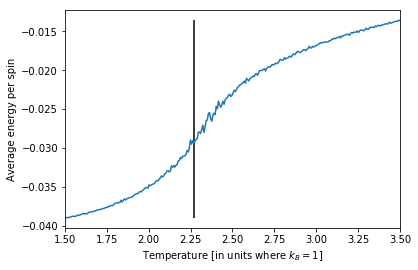

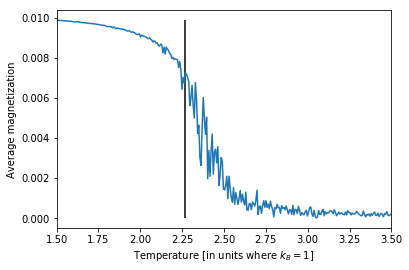

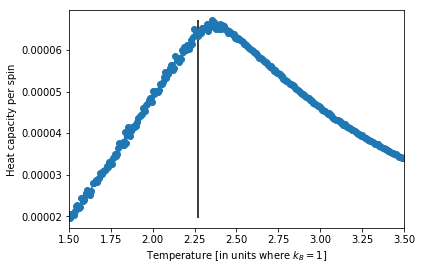

In [3]:
simulation(100, (64, 64))

2.3561872909698995

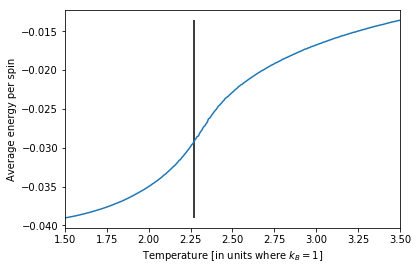

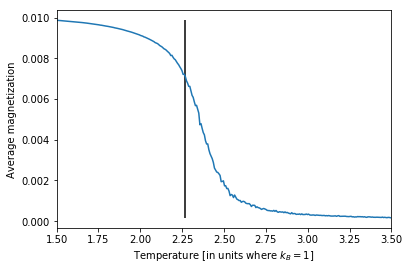

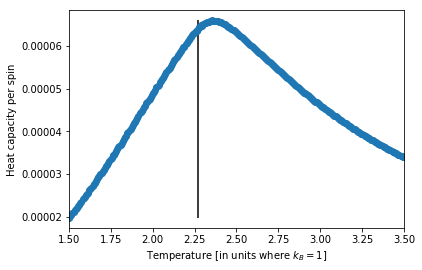

In [4]:
from scipy.optimize import minimize_scalar
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    def minimizable_function(T, size, iterations, np):
        print(f"Running for T = {T}")
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result =  minimize_scalar(fun=minimizable_function,
                       bounds = [2, 3],
                       method="bounded",
                       args=(size, iterations, np),
                       options=dict(disp=True))
    return result
print(Onsager_critical_temperature)
result = smart_optimization(
    size = (512, 512),
    iterations = 1200
)
result

All right, that's smoother, though at the same time it went much slower. How much slower? Let's take a look:

In [18]:
from datetime import datetime
gpu_array_lengths = [2**n for n in range(6, 11)]
cpu_times = {}
gpu_times = {}
for n in gpu_array_lengths:
    size = (n, n)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    a_mask = get_mask(size)
    cpu_times[n] = %timeit -o func(200, size, 1, a_mask = a_mask)
    a_mask = get_mask(size, np = cupy)
    gpu_times[n] = %timeit -o func(200, size, 1, a_mask = a_mask, np=cupy)

05:55:54: (64, 64) grid
98.6 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
900 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
05:56:09: (128, 128) grid
179 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.07 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
05:56:33: (256, 256) grid
1.07 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 52.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
05:56:50: (512, 512) grid
3.47 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NumPy and CuPy equalize at the (256, 256) grid size mark, and from then on it's smooth sailing in favour of CuPy, as is expected. On my system, NumPy starts slowing down at the (1024, 1024) mark, but that appears to be simply a memory issue. Let's take a visual look:

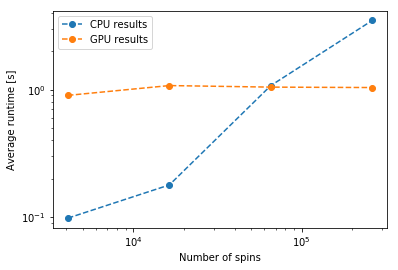

In [19]:
plt.loglog(np.array(gpu_array_lengths)**2, [t.average for t in cpu_times.values()],
            "o--", label="CPU results")
plt.loglog(np.array(gpu_array_lengths)**2,
             [t.average for t in gpu_times.values()],
            "o--", label="GPU results")
plt.legend();
plt.xlabel("Number of spins")
plt.ylabel("Average runtime [s]");

In [49]:
import scipy
from scipy.optimize import minimize
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")

    def minimizable_function(T, size, iterations, np):
        T = T[0]
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result =  minimize(fun=minimizable_function,
                       x0=Onsager_critical_temperature,
                       args=(size, iterations, np))
    return result
result = smart_optimization(
    size = (512, 512),
    iterations = 200
)
result

06:15:52: (512, 512) grid


      fun: -1.483344171763875
 hess_inv: array([[1]])
      jac: array([-85092.47804661])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 78
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([2.26918531])

In [50]:
gpu_array_lengths = [2**n for n in range(6, 13)]
results = [smart_optimization((s, s), 200) for s in gpu_array_lengths]

06:17:17: (64, 64) grid
06:18:33: (128, 128) grid
06:19:48: (256, 256) grid
06:20:57: (512, 512) grid
06:22:27: (1024, 1024) grid
06:24:52: (2048, 2048) grid
06:36:37: (4096, 4096) grid


NameError: name 'reults' is not defined

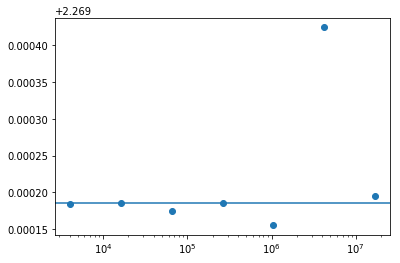

In [54]:
grid_sizes = [s**2 for s in gpu_array_lengths]
critical_temperatures = [result.x[0] for result in results]
plt.semilogx(grid_sizes, critical_temperatures, "o")
plt.axhline(Onsager_critical_temperature)

And what of the lower grid sizes?

07:34:00: (4, 4) grid
07:34:03: (8, 8) grid
07:34:07: (16, 16) grid
07:34:14: (32, 32) grid
07:34:20: (64, 64) grid


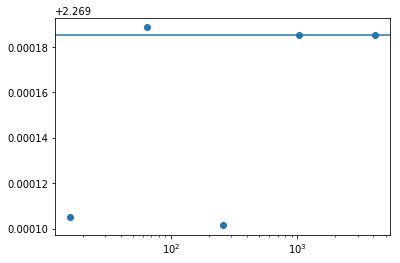

In [55]:
array_lengths = [2**n for n in range(2, 7)]
cpu_results = [smart_optimization((s, s), 200, numpy) for s in array_lengths]
grid_sizes = [s**2 for s in array_lengths]
critical_temperatures = [result.x[0] for result in cpu_results]
plt.semilogx(grid_sizes, critical_temperatures, "o")
plt.axhline(Onsager_critical_temperature)

It probably makes sense to look at the effect decreasing 

07:35:15: (64, 64) grid
07:35:17: (128, 128) grid
07:35:19: (256, 256) grid
07:35:21: (512, 512) grid
07:35:23: (1024, 1024) grid


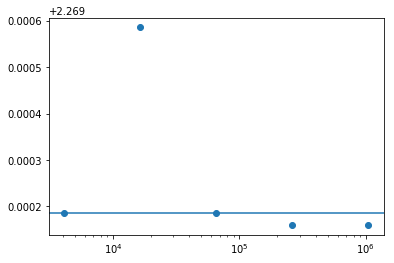

In [56]:
gpu_array_lengths = [2**n for n in range(6, 10)]
low_iteration_results = [smart_optimization((s, s), 600) for s in gpu_array_lengths]
grid_sizes = [s**2 for s in gpu_array_lengths]
critical_temperatures = [result.x[0] for result in low_iteration_results]
plt.semilogx(grid_sizes, critical_temperatures, "o")
plt.axhline(Onsager_critical_temperature)

In [61]:
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    def minimizable_function(T, size, iterations, np):
        T = T[0]
        print(f"Running for T = {T}")
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result =  minimize(fun=minimizable_function,
                       x0=2,
                       args=(size, iterations, np),
                       options=dict(disp=True))
    return result
result = smart_optimization(
    size = (512, 512),
    iterations = 600
)
result

07:40:55: (512, 512) grid
Running for T = 2.0
Running for T = 2.000000014901161
Running for T = 2.0
Running for T = 3.01
Running for T = 3.01
Running for T = 3.010000014901161
Running for T = 2.535766254864029
Running for T = 2.535766254864029
Running for T = 2.5357662697651904
Running for T = 2.5360943548036476
Running for T = 2.5360943548036476
Running for T = 2.536094369704809
Running for T = 2.53583385275895
Running for T = 2.53583385275895
Running for T = 2.535833867660111
Running for T = 2.535773960104239
Running for T = 2.535773960104239
Running for T = 2.5357739750054002
Running for T = 2.5357674973146147
Running for T = 2.5357674973146147
Running for T = 2.535767512215776
Running for T = 2.5357693381635817
Running for T = 2.5357693381635817
Running for T = 2.535769353064743
Running for T = 2.535768205969628
Running for T = 2.535768205969628
Running for T = 2.5357682208707892
Running for T = 2.535768831865849
Running for T = 2.535768831865849
Running for T = 2.5357688467670103


      fun: -1.6040059198916767
 hess_inv: array([[1.21092014e-09]])
      jac: array([-2087.81764354])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 73
      nit: 2
     njev: 21
   status: 2
  success: False
        x: array([2.53576824])

In [68]:
from scipy.optimize import minimize_scalar
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    def minimizable_function(T, size, iterations, np):
        print(f"Running for T = {T}")
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result =  minimize_scalar(fun=minimizable_function,
                       bounds = [2, 3],
                       method="bounded",
                       args=(size, iterations, np),
                       options=dict(disp=True))
    return result
result = smart_optimization(
    size = (512, 512),
    iterations = 600
)
result

07:58:07: (512, 512) grid
Running for T = 2.381966011250105
Running for T = 2.618033988749895
Running for T = 2.23606797749979
Running for T = 2.4752622191396902
Running for T = 2.4303831784176864
Running for T = 2.4297609735024155
Running for T = 2.411504922413051
Running for T = 2.421304682036599
Running for T = 2.425069597957112
Running for T = 2.4175615069419827
Running for T = 2.4242978312957826
Running for T = 2.4198749163762976
Running for T = 2.418991272602284
Running for T = 2.4202898742865173
Running for T = 2.419871547150419
Running for T = 2.420033416194101
Running for T = 2.419935457919488
Running for T = 2.419898041188065
Running for T = 2.4199123331077206
Running for T = 2.4198892082959533
Running for T = 2.419903500215609
Running for T = 2.419894667323497

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -1.6222616366401172
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 2.419898041188065

In [ ]:
print("boo")

In [71]:
from scipy.optimize import minimize_scalar
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    def minimizable_function(T, size, iterations, np):
        print(f"Running for T = {T}")
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result =  minimize_scalar(fun=minimizable_function,
                       bounds = [2, 3],
                       method="bounded",
                       args=(size, iterations, np),
                       options=dict(disp=True))
    return result
print(Onsager_critical_temperature)
result = smart_optimization(
    size = (512, 512),
    iterations = 1200
)
result

2.269185314213022
08:04:20: (512, 512) grid
Running for T = 2.381966011250105
Running for T = 2.618033988749895
Running for T = 2.23606797749979
Running for T = 2.474179502689605
Running for T = 2.4240599540941496
Running for T = 2.425521194023024
Running for T = 2.4099258810864654
Running for T = 2.4186612186046865
Running for T = 2.4203922105203683
Running for T = 2.421305576726152
Running for T = 2.4197310304428292
Running for T = 2.420741085366802
Running for T = 2.420139662203433
Running for T = 2.420525468853886
Running for T = 2.4202957456471004
Running for T = 2.420443110674488
Running for T = 2.4203553642175004
Running for T = 2.4204116526492094
Running for T = 2.4203781364850325
Running for T = 2.420399636752772
Running for T = 2.420386834717229
Running for T = 2.4203955797539196

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


     fun: -1.626577461517394
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 2.4203922105203683

In [72]:
%pip install noisyopt

Note: you may need to restart the kernel to use updated packages.


In [73]:
from noisyopt import minimizeCompass

In [82]:

from scipy.optimize import minimize_scalar
def smart_optimization(size, iterations, np=cupy):
    a_mask = get_mask(size, np)
    print(f"{datetime.now().strftime('%H:%M:%S')}: {size} grid")
    def minimizable_function(T, size, iterations, np):
        T = T[0]
#         print(f"Running for T = {T}")
        _, _, _, E_std, _ = func(iterations, size, T, a_mask, np = np)
        return -cv(E_std, T, k_b)  # minus because we wish to find the maximum
    result = minimizeCompass(minimizable_function, bounds=[[2, 3]], x0=[2], deltatol=0.01, paired=False, 
                                                   args=(size, iterations, np),
                             disp=True,
    )
    return result
print(Onsager_critical_temperature)
result = smart_optimization(
    size = (512, 512),
    iterations = 500
)
result

2.269185314213022
08:16:39: (512, 512) grid
minimization starting
args ((512, 512), 500, <module 'cupy' from '/progs/miniconda3/envs/cupy/lib/python3.7/site-packages/cupy/__init__.py'>)
errorcontrol True
paired False
nit 1, Delta 1
[3.]
nit 2, Delta 1
nit 3, Delta 0.5
[2.5]
nit 4, Delta 0.5
nit 5, Delta 0.25
nit 6, Delta 0.125
[2.375]
nit 7, Delta 0.125
nit 8, Delta 0.0625
[2.4375]
nit 9, Delta 0.0625
nit 10, Delta 0.03125
nit 11, Delta 0.01
[2.4275]
nit 12, Delta 0.01
    free: array([False])
     fun: -1.6204060927701756
   funse: 5.06915059378439e-05
 message: 'convergence within deltatol'
    nfev: 360
     nit: 12
 success: True
       x: array([2.4275])


    free: array([False])
     fun: -1.6204060927701756
   funse: 5.06915059378439e-05
 message: 'convergence within deltatol'
    nfev: 360
     nit: 12
 success: True
       x: array([2.4275])